In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import numpy as np
save_dir = '/content/drive/MyDrive/Python/ezoic/'

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


#Query Data

In [2]:
def query_db(query):
	'''
	Runs sql query on 311 database and returns a pandas DataFrame.
	Redshift is a data warehouse based on PostgreSQL, so syntax is mostly the same
	'''
	host = 'interview-ds.ckgnwnm6pw4o.us-east-1.redshift.amazonaws.com'
	port = 5439
	db = 'interview'
	username = 'dsguest'
	password = 'nX9EFYUZ5Yu#0q'
	conn = psycopg2.connect(host=host, port=port, dbname=db, user=username, password=password)
	cur = conn.cursor()
	cur.execute(query)
	rows = cur.fetchall()
	df = pd.DataFrame(rows)
	return df

Records with empty descriptor field

In [3]:
empty_descriptor = "SELECT COUNT(unique_key) from public.three_one_one WHERE descriptor IS  NULL OR descriptor='';"
ct_empties = query_db(empty_descriptor)[0][0]
print(print("ct rows with an empty descriptor field", "{:,}".format(ct_empties)))

ct rows with an empty descriptor field 34,537
None


In [4]:
min_freq = pow(10,2)
where = "WHERE (descriptor IS NOT NULL AND descriptor!='')  "

Grab Category Information

In [5]:
sub = "SELECT COUNT(UNIQUE_KEY) count, complaint_type FROM public.three_one_one " + where + ' GROUP BY complaint_type'
count_complaint_type = "SELECT count, complaint_type FROM (" + sub + ") sub WHERE sub.count > " + str(min_freq) + " ORDER BY sub.count DESC"
print(count_complaint_type)
df_compl = query_db(count_complaint_type + ';')
df_compl.columns = ['count','complaint_type']
print("complaint types used:", df_compl.shape[0])
all_complaint_type = "SELECT DISTINCT COMPLAINT_TYPE FROM public.three_one_one ;"
df_all_compl = query_db(all_complaint_type)
print("count all complaint types:", df_all_compl.shape[0])

SELECT count, complaint_type FROM (SELECT COUNT(UNIQUE_KEY) count, complaint_type FROM public.three_one_one WHERE (descriptor IS NOT NULL AND descriptor!='')   GROUP BY complaint_type) sub WHERE sub.count > 100 ORDER BY sub.count DESC
complaint types used: 237
count all complaint types: 433


Grab Data for Training

In [6]:
limit = 5*pow(10,4)

##shuffle the data sampling to train on by ordering by different fields
fields = ['incident_zip', 'created_date', 'unique_key', 'location_type', 'cross_street_1', 'longitude', 'community_board', 'city', 'address_type', 'borough']
rand_int = np.random.randint(0, high=len(fields)-1)
descriptor_data = "SELECT unique_key, descriptor, threeoneone.complaint_type FROM public.three_one_one threeoneone "
descriptor_data += "INNER JOIN ("+sub+") sub ON sub.complaint_type=threeoneone.complaint_type"
descriptor_data += ' ' + where + "AND (sub.count > "+str(min_freq)+")"
descriptor_data += ' ORDER BY '+fields[rand_int]+ ' '
descriptor_data += ' LIMIT ' +str(limit) + ';'
print(descriptor_data)
df = query_db(descriptor_data)
df.columns = ['ID', 'descriptor', 'complaint_type']
print("sub-sampled dataset size:", "{:,}".format(df.shape[0]))

SELECT unique_key, descriptor, threeoneone.complaint_type FROM public.three_one_one threeoneone INNER JOIN (SELECT COUNT(UNIQUE_KEY) count, complaint_type FROM public.three_one_one WHERE (descriptor IS NOT NULL AND descriptor!='')   GROUP BY complaint_type) sub ON sub.complaint_type=threeoneone.complaint_type WHERE (descriptor IS NOT NULL AND descriptor!='')  AND (sub.count > 100) ORDER BY unique_key  LIMIT 50000;
sub-sampled dataset size: 50,000


Preview Data

In [7]:
print(df)

             ID                  descriptor       complaint_type
0      10564222              Mouse Sighting               Rodent
1      10693408              Mouse Sighting               Rodent
2      10836749            Signs of Rodents               Rodent
3      10836967            Signs of Rodents               Rodent
4      11051177              Mouse Sighting               Rodent
...         ...                         ...                  ...
49995  15694059                Out of Order    Broken Muni Meter
49996  15694061            Loud Music/Party  Noise - Residential
49997  15694062                 Illegal Tow   Consumer Complaint
49998  15694063                  No Receipt    Broken Muni Meter
49999  15694064  Credit Card Stuck in Meter    Broken Muni Meter

[50000 rows x 3 columns]



#Setup Data for Training

In [8]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [9]:
print("shuffled data")
df = df.sample(frac=1).reset_index(drop=True)

shuffled data


In [10]:
def sentence_lengths(sequences):
  print("sentence lengths")
  lens = []
  for sent in sequences:
    lens.append(len(sent))
  lens = np.array(lens)
  print("max:", lens.max())
  print("avg +- std:", round(lens.mean(),2), " +- ", round(lens.std(),2))

In [11]:
class Data():
  def __init__(self, df, categ, max_length = 5, num_words = 256, split=0.15):
    self.df = df
    self.train = {'raw':{},'input':{} }
    self.dev = {'raw':{},'input':{} }
    self.test = {'raw':{},'input':{} }
    self.max_length = max_length 
    self.vocab_size = num_words
    self.split = split
    self.categories = list(categ)
    self.ct_categories = len(self.categories)
    self.categ_index = {}
  def split_data(self):
    split = self.split
    train_ind = int((1 - split*2)*df.shape[0])
    dev_ind = (df.shape[0] - train_ind)//2 + train_ind
    descriptor = df['descriptor'].to_numpy()
    complaints = df['complaint_type'].to_numpy()
    self.train['raw']['x'] = descriptor[:train_ind]
    self.train['raw']['y'] = complaints[:train_ind]
    self.dev['raw']['x']   = descriptor[train_ind:dev_ind]  
    self.dev['raw']['y']   = complaints[train_ind:dev_ind]  
    self.test['raw']['x']  = descriptor[dev_ind:]
    self.test['raw']['y']  = complaints[dev_ind:]
  def tokenize(self):
    '''setup tokenizer'''
    self.tokenizer = Tokenizer(num_words=self.vocab_size ,oov_token="<OOV>")
    self.tokenizer.fit_on_texts(self.train['raw']['x'])
    print("unique words:",self.vocab_size) 
    print(str(self.tokenizer.word_index)[:150], '...')
  def prepare_x(self):
    sequences = self.tokenizer.texts_to_sequences(self.train['raw']['x'])  
    sentence_lengths(sequences)
    self.train['input']['x'] = pad_sequences(sequences, maxlen=self.max_length, padding='pre', truncating='pre')
    print("shape training x", self.train['input']['x'].shape)
    print('truncating & padding to length:', self.max_length)
    sequences = self.tokenizer.texts_to_sequences(self.dev['raw']['x'])  
    self.dev['input']['x'] = pad_sequences(sequences, maxlen=self.max_length, padding='pre', truncating='pre')    
    sequences = self.tokenizer.texts_to_sequences(self.test['raw']['x'])  
    self.test['input']['x'] = pad_sequences(sequences, maxlen=self.max_length, padding='pre', truncating='pre')    
  def one_hot_y(self, y):
    '''takes in list of categories as strings, returns 2-D matrix of one hot 
    encoded vectors'''
    size = y.shape[0]
    ynp = np.zeros(size)
    for i in range(size):
      try:
        ynp[i] = self.categ_index[y[i]]
      except:
        print("size", size)
        print("index", i)
        print("y", y[i])
    return  keras.utils.to_categorical(ynp, num_classes=self.ct_categories)
  def prepare_y(self):
    ##setup a custom mapping to go from category to index
    print("categories")
    print(str(self.categories)[:150], "...")
    for i, wrd in enumerate(self.categories):
      self.categ_index[wrd] = i
    self.train['input']['y'] = self.one_hot_y(self.train['raw']['y'])
    print("shape training y", self.train['input']['y'].shape)
    self.dev['input']['y'] = self.one_hot_y(self.dev['raw']['y'])
    self.test['input']['y'] = self.one_hot_y(self.test['raw']['y'])
  def prepare_data(self):
    '''prepare data for training
    tokenize and pad the data'''
    self.prepare_x()
    self.prepare_y()


In [ ]:
data = Data(df, df_compl['complaint_type'])
data.split_data()
data.tokenize()
data.prepare_data()

#Training

##Choose Your Model Architecture

In [ ]:
embedding_dim = 64
vocab_size = data.vocab_size
max_length = data.max_length
ct_categories = data.ct_categories
def create_model(mode):
  if mode=='LSTM':
    model = keras.Sequential([
        keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        keras.layers.Bidirectional(keras.layers.LSTM(16)),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(ct_categories, activation='softmax')
    ])
  elif mode=='GRU':
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(ct_categories, activation='softmax')
    ])
  elif mode=='CONVD':
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Conv1D(32, 5, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(ct_categories, activation='softmax')
    ])    
  return model  
model = create_model('LSTM')  
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy', 'Precision', 'Recall'])
model.summary()

In [ ]:
history = model.fit(data.train['input']['x'] , data.train['input']['y'], validation_data=(data.dev['input']['x'], data.dev['input']['y'] ), epochs=5)

Epoch 1/5
1094/1094 [==============================] - 13s 8ms/step - loss: 1.8428 - accuracy: 0.5903 - precision: 0.9852 - recall: 0.4660 - val_loss: 0.7484 - val_accuracy: 0.8485 - val_precision: 0.9836 - val_recall: 0.7764
Epoch 2/5
1094/1094 [==============================] - 8s 7ms/step - loss: 0.5246 - accuracy: 0.8937 - precision: 0.9830 - recall: 0.8567 - val_loss: 0.4376 - val_accuracy: 0.9063 - val_precision: 0.9804 - val_recall: 0.8787
Epoch 3/5
1094/1094 [==============================] - 7s 7ms/step - loss: 0.3590 - accuracy: 0.9188 - precision: 0.9831 - recall: 0.8988 - val_loss: 0.3394 - val_accuracy: 0.9229 - val_precision: 0.9788 - val_recall: 0.8992
Epoch 4/5
1094/1094 [==============================] - 8s 7ms/step - loss: 0.2912 - accuracy: 0.9319 - precision: 0.9832 - recall: 0.9108 - val_loss: 0.2907 - val_accuracy: 0.9323 - val_precision: 0.9781 - val_recall: 0.9132
Epoch 5/5
1094/1094 [==============================] - 7s 7ms/step - loss: 0.2489 - accuracy: 0.938

In [ ]:
def plot_graphs(history, string, save_dir):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.title(string)
  plt.savefig(save_dir + string)

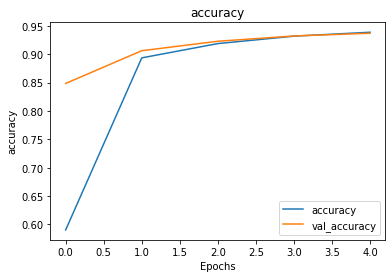

In [ ]:
plot_graphs(history, 'accuracy', save_dir)

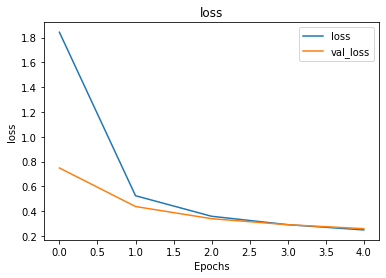

In [ ]:
plot_graphs(history, 'loss', save_dir)


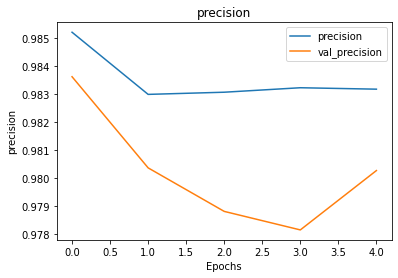

In [ ]:
plot_graphs(history, 'precision', save_dir)

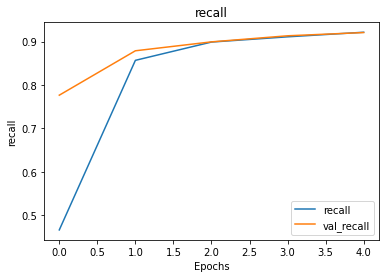

In [ ]:
plot_graphs(history, 'recall', save_dir)

In [ ]:
res = model.evaluate(data.test['input']['x'], data.test['input']['y'])
print("Final Accuracy", round(res[1]*100,2), "%")

235/235 [==============================] - 1s 2ms/step - loss: 0.2500 - accuracy: 0.9412 - precision: 0.9833 - recall: 0.9256
Final Accuracy 94.12 %
